In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

from jax.example_libraries import optimizers

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from functools import partial
from sklearn.datasets import fetch_openml
import networkx as nx

In [116]:
n = 34
g = nx.karate_club_graph()
# L = nx.laplacian_matrix(g).toarray()] これだと変なラプラシアンがとれる？
ad_mat = np.sign(nx.adjacency_matrix(g).toarray())
dg_mat = np.diag(np.sum(ad_mat, axis=0))
L = dg_mat - ad_mat + 1e-12*np.eye(len(ad_mat))
eig = LA.eigvals(L)
lmin = np.partition(eig, 1)[1]
lmax = np.partition(eig, n-1)[n-1]
# lmax = np.max(eig)
eta_opt = 2.0/(lmin + lmax)

K = 200
num_itr = 100
adam_lr = 5e-5
max_inner = 50#50
L = jnp.array(L)

In [117]:
def consensus(max_itr, x0):
    x = x0
    for i in range(max_itr):
        x = (jnp.eye(len(L)) - eta_opt*L)@x
    return x

In [118]:
def mini_batch(K):
    x0 = jnp.array(np.random.randn(n, K))
    c = jnp.sum(x0, axis=0)
    r = jnp.tile(c, (n, 1))/n
    return x0, r

In [119]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [120]:
def comp_mes(max_itr):
    x0, c = mini_batch(K)
    x_hat = consensus(max_itr, x0)
    return jnp.sum(batch_get_dot(c-x_hat))/K

In [121]:
consensus_mse = [float(comp_mes(i+1)) for i in range(num_itr)]

In [122]:
df = pd.DataFrame()
df["Iteration"] = range(1, num_itr+1)
df["Consensus(fixed step size)"] = consensus_mse

In [123]:
def DU_consensus(max_itr, x0, eta):
    x = x0
    for i in range(max_itr):
        x = (jnp.eye(len(L)) - eta_opt*L)@x
    return x

In [124]:
def loss(max_itr, x_opt, x0, eta):
    x_hat = DU_consensus(max_itr, x0, eta)
    return jnp.sum(batch_get_dot(x_opt - x_hat))/K

In [125]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=0)
def step(max_itr, x_opt, y, step_num, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(max_itr, x_opt, y, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(eta):
    opt_state = opt_init(eta)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y, x_opt = mini_batch(K)
            value, opt_state = step(itr+1, x_opt, y, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [126]:
def comp_mse_DU_consensus(max_itr, eta):
    x0, c = mini_batch(K)
    x_hat = DU_consensus(max_itr, x0, eta)
    return jnp.sum(batch_get_dot(c-x_hat))/K

In [127]:
eta_init = jnp.zeros(num_itr)
eta_trained = train(eta_init)

  0%|          | 0/100 [00:00<?, ?it/s]

loss:6.812036735936999e-05  

In [128]:
DU_consensus_mse = [float(comp_mse_DU_consensus(i+1, eta_trained)) for i in range(num_itr)]

In [129]:
df["DU-consensus"] = DU_consensus_mse

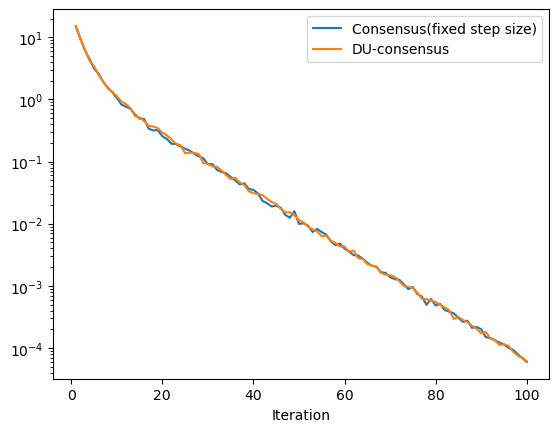

In [130]:
df.plot(x = "Iteration", y = df.columns[1:])
plt.yscale("log")